# Full Ridge Implementation with Sketches

In [110]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

In [2]:
fpath = 'datasets/'
transformed = np.load(fpath+'transformed_training_set.npy')#np.load(fpath+'train_transformed.npy')
train = np.load(fpath+'train.npy')
valid = np.load(fpath+'validate.npy')
test  = np.load(fpath+'test.npy')

X_tr   , y_tr    = transformed[:,:-1],transformed[:,-1]
X_train, y_train = train[:,:-1], train[:,-1]
X_valid, y_valid = valid[:,:-1], valid[:,-1]
X_test,  y_test   = test[:,:-1], test[:,-1]

print(f'Transformed sizes: {X_tr.shape, y_tr.shape}')
print(f'Training sizes: {X_train.shape, y_train.shape}')
print(f'Validation size: {X_valid.shape, y_valid.shape}')
print(f'Testing size: {X_test.shape, y_test.shape}')

y_mean = np.mean(np.concatenate((y_train, y_valid, y_test),axis=0))
for yy in [y_train, y_valid, y_test]:
    yy -= y_mean
    
X_train_poly = PolynomialFeatures(degree=3).fit_transform(X_train)
X_valid_poly   = PolynomialFeatures(degree=3).fit_transform(X_valid)
X_test_poly  = PolynomialFeatures(degree=3).fit_transform(X_test)

print(f'Training sizes: {X_train_poly.shape, y_train.shape}')
print(f'Validation size: {X_valid_poly.shape, y_valid.shape}')
print(f'Testing size: {X_test_poly.shape, y_test.shape}')

Transformed sizes: ((16512, 16), (16512,))
Training sizes: ((13209, 16), (13209,))
Validation size: ((3303, 16), (3303,))
Testing size: ((4128, 16), (4128,))
Training sizes: ((13209, 969), (13209,))
Validation size: ((3303, 969), (3303,))
Testing size: ((4128, 969), (4128,))


Here, our dataset is already split into train, validation and test splits.
Let's apply our model to replicate the sklearn behaviour.
Firstly, we need to define our exact ridge estimator.

In [8]:
# Model hyperparameters
n_train = X_train_poly.shape[0]
gammas = [10**_ for _ in np.arange(-5,8,step=0.25)]

In [9]:
# Model output arrays
my_train_errors = np.zeros_like(len(gammas),dtype=float)
my_valid_errors = np.zeros_like(my_train_errors)
my_test_errors = np.zeros_like(my_train_errors)

In [72]:
import scipy.sparse as sp
from scipy import linalg
from scipy import sparse
from scipy.sparse import linalg as sp_linalg

class RidgeRegression:
    def __init__(self,gamma):
        self.gamma = gamma
        self.params = {
            a : {
            'coef_'   :  None,
                     } for a in self.gamma}
        
    def fit(self,data,targets):
        training_data, training_targets = self._preprocess_data(data, targets)
        u, s, vt = linalg.svd(training_data, full_matrices=False)
        for a in self.gamma:
            # There should be either 1 or n_targets penalties
            gamma_reg = np.asarray(a, dtype=data.dtype).ravel() # shift regularisation by the alpha parameter
            assert gamma_reg.size == 1
            weights = self._solve(u,s,vt,training_targets,gamma_reg)
            self.params[a]['coef_'] = weights
        
    def _preprocess_data(self,X,y):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        self.scaler_mean = scaler.mean_
        self.scaler_scale_ = scaler.scale_
        self.intercept = y.mean()
        return X_scaled, y - self.intercept
    
    def _solve(self, U,s,Vt,y,alpha):
        idx = s > 1e-15  # same default value as scipy.linalg.pinv
        s_nnz = s[idx][:, np.newaxis]
        UTy = np.dot(U.T, y)[:,np.newaxis]
        d = np.zeros((s.size, alpha.size), dtype=U.dtype)
        d[idx] = s_nnz / (s_nnz ** 2 + alpha)
        d_UT_y = np.squeeze(d * UTy) # squeeze to a single dimension
        sol = Vt.T@d_UT_y
        return sol#np.dot(Vt.T, d_UT_y)

    def predict(self,A,weights):
        '''
        Intercept is default None but with the option of being not None if the 
        targets were zero centred prior to fitting the model.
        '''
        scaled_data = (A - self.scaler_mean) / self.scaler_scale_
        return scaled_data@weights + self.intercept
    
    def get_predictions(self,A,regulariser):
        """
        returns the predictions for a chosen regularisation parameter
        (useful for getting the test predictions)
        """
        scaled_data = (A - self.scaler_mean) / self.scaler_scale_
        weights = self.params[regulariser]['coef_']
        return scaled_data@weights + self.intercept
    
    def _error(self, y_pred, y_true):
        return (1./np.sqrt(len(y_pred)))*np.linalg.norm(y_pred - y_true)
    
    def get_errors(self,data,labels):
        """
        Returns the array of errors for (data,labels) where data can be 
        any of the train,validate or test sets.
        """
        all_errors = np.zeros(len(self.gamma))
        for i,a in enumerate(self.gamma):
            y_pred = self.predict(data,self.params[a]['coef_'])
            _error = self._error(y_pred,labels)
            all_errors[i] = _error
        return all_errors

        
        

In [15]:
my_ridge = RidgeRegression(gammas)
my_ridge.fit(X_train_poly,y_train)
my_train_errors = my_ridge.get_errors(X_train_poly,y_train)
my_valid_errors = my_ridge.get_errors(X_valid_poly,y_valid)
my_test_errors = my_ridge.get_errors(X_test_poly,y_test)

In [22]:
# Optimal hyperparameter selection and test loss
exact_optimal_gamma = gammas[my_valid_errors.argmin()]
exact_test_error = my_test_errors[my_valid_errors.argmin()]

In [31]:
print(f'Optimal gamma:{exact_optimal_gamma}\nTest Error:{exact_test_error:.5f}')

Optimal gamma:100.0
Test Error:0.00955


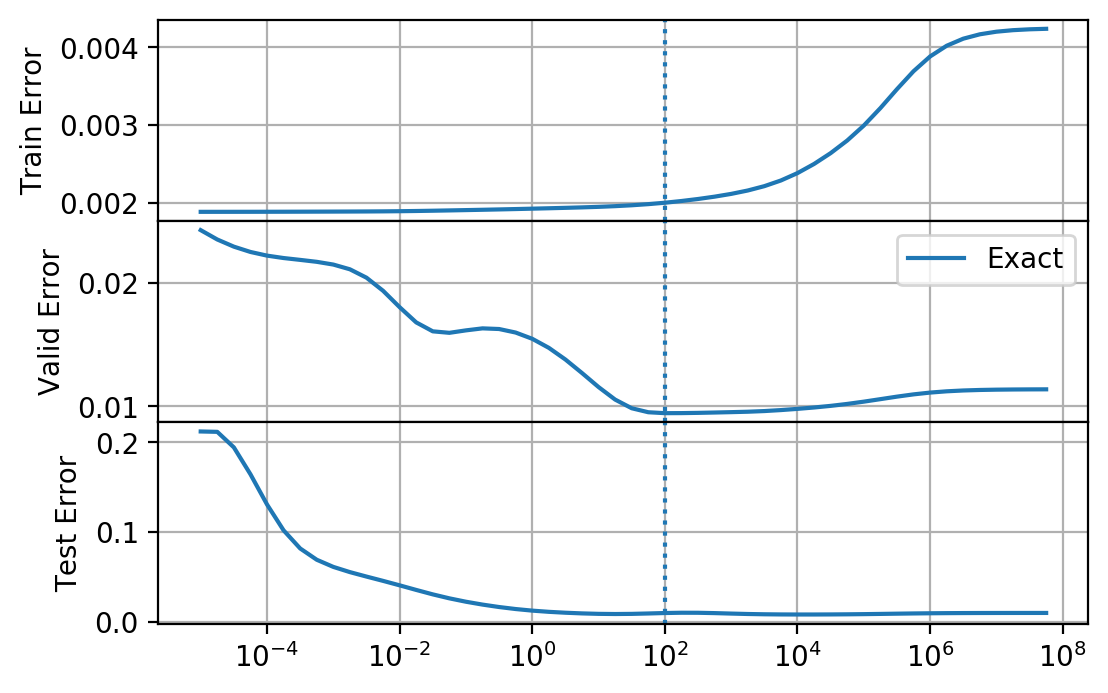

In [25]:
fig, axes = plt.subplots(nrows=3,dpi=200,gridspec_kw = {'hspace':0})
ax_tr, ax_va, ax_te = axes


ax_tr.plot(gammas, my_train_errors,label='Exact')

ax_va.plot(gammas, my_valid_errors,label='Exact')

ax_te.plot(gammas, my_test_errors,label='Exact')

ax_tr.set_ylabel('Train Error')
ax_va.set_ylabel('Valid Error')
ax_te.set_ylabel('Test Error')


for ax in axes:
    ax.set_xscale('log',basex=10)
    ax.axvline(exact_optimal_gamma,color='C0',linestyle=':')
    ax.grid()
ax_va.legend()

## 2. Sketching Ridge Regression with FD

Now let's do the same thing with an FD implementation for sketching.

In [26]:
import sys
import os
from pathlib import Path
path = Path(os.getcwd())
sys.path.append(str(path.parent.parent/ 'src'))#/frequent_directions.py'))
from frequent_directions import FastFrequentDirections,RobustFrequentDirections

In [27]:
class FDRR(RidgeRegression):
    """
    Implements the Frequent Directions Reidge Regression
    """
    def __init__(self, fd_dim:int,gamma,fd_mode='FD',solve_method='Exact'):
        """
        Approximate ridge regression using the FD sketch.

        fd_dim (int) - the number of rows retained in the FD sketch.
        fd_mode (str) : mode for frequent directions FD or RFD.
        gamma : float - the regularisation parameter for ridge regression.
        """
        self.fd_dim       = fd_dim
        self.fd_mode      = fd_mode
        self.solve_method = solve_method
        if self.fd_mode not in ['FD', 'RFD']:
            raise NotImplementedError('Only F(ast) and R(obust) FD methods are supported.')
        if self.solve_method not in ['Exact','ShiWoodbury']:
            raise NotImplementedError('Only Exact and ShiWoodbury methods are implemented')
        self.gamma        = gamma
        if not isinstance(gamma,list):
            self.gamma = [gamma]
        else:
            self.gamma = gamma
            
    def fit(self,data,targets):
        '''
        Fits the ridge model to gamma (which can be a single float or list/ndarray).
        '''
        _,d = data.shape
        X, y = self._preprocess_data(data, targets)
        # Perform self._sketch() once to avoid recomputing
        self._sketch(X) 
        self.params = {
            a : {
            'coef_'   :  np.zeros(d)
                     } for a in self.gamma}
        # Can potentially parallelise this loop for better time performance
        for a in self.gamma:
            # There should be either 1 or n_targets penalties
            gamma_reg = np.asarray(a+self.alpha, dtype=X.dtype).ravel() # shift regularisation by the alpha parameter
            assert gamma_reg.size == 1
            weights = self._solve(X,y,gamma_reg)
            #intercept = self._set_intercept(weights,X_offset, y_offset, X_scale)
            self.params[a]['coef_'] = weights
            #self.params[a]['intercept'] = intercept
            
    def _sketch(self,X):
        if self.fd_mode == 'FD':
            sketcher = FastFrequentDirections(X.shape[1],sketch_dim=self.fd_dim)
        elif self.fd_mode == 'RFD':
            sketcher = RobustFrequentDirections(X.shape[1],sketch_dim=self.fd_dim)
        sketcher.fit(X,batch_size=self.fd_dim)
        self.V = sketcher.Vt.T
        self.SigmaSquared = sketcher.sigma_squared
        self.sketch_mat = sketcher.sketch
        self.alpha = sketcher.delta # == 0 if using FastFrequentDirections so can use self.gamma + self.alpha everywhere 
        
    def _solve(self,X,y,reg):
        if self.solve_method == 'ShiWoodbury':
            return self._small_space_solve(X,y,reg)
        else:
            # The exact / naive method
            return (np.linalg.pinv(self.sketch_mat.T@self.sketch_mat + reg*np.eye(X.shape[1])))@(X.T@y)
        
    def _small_space_solve(self,X,y,reg):
        '''
        Solves in small space using the algorithm of shi and phillips.
        This is just Woodbury identity but over the basis and singular values rather than 
        the raw sketch.
        '''
        ATy = X.T@y
        inv_diag = np.linalg.pinv(np.diag(self.SigmaSquared + reg)) #1./(S**2 + self.gamma)
        first_term = (self.V@(inv_diag))@(self.V.T@ATy)
        second_term = (1./reg)*ATy
        third_term = (1./reg)*self.V@(self.V.T@ATy)
        return first_term + second_term - third_term
        

In [28]:
# FD Model output arrays
fd_ridge = FDRR(fd_dim=256,gamma=gammas,fd_mode='RFD',solve_method='ShiWoodbury')
fd_ridge.fit(X_train_poly,y_train)
fd_train_errors = fd_ridge.get_errors(X_train_poly,y_train)
fd_validation_errors = fd_ridge.get_errors(X_valid_poly,y_valid)
fd_test_errors = fd_ridge.get_errors(X_test_poly,y_test)

In [30]:
# Optimal hyperparameter selection and test loss for FD
fd_optimal_gamma = gammas[fd_validation_errors.argmin()]
fd_test_error = fd_test_errors[fd_validation_errors.argmin()]

In [32]:
print(f'FD gamma:{fd_optimal_gamma}\nFD Test Error:{fd_test_error:.5f}')

FD gamma:316.22776601683796
FD Test Error:0.01059


(0, 0.1)

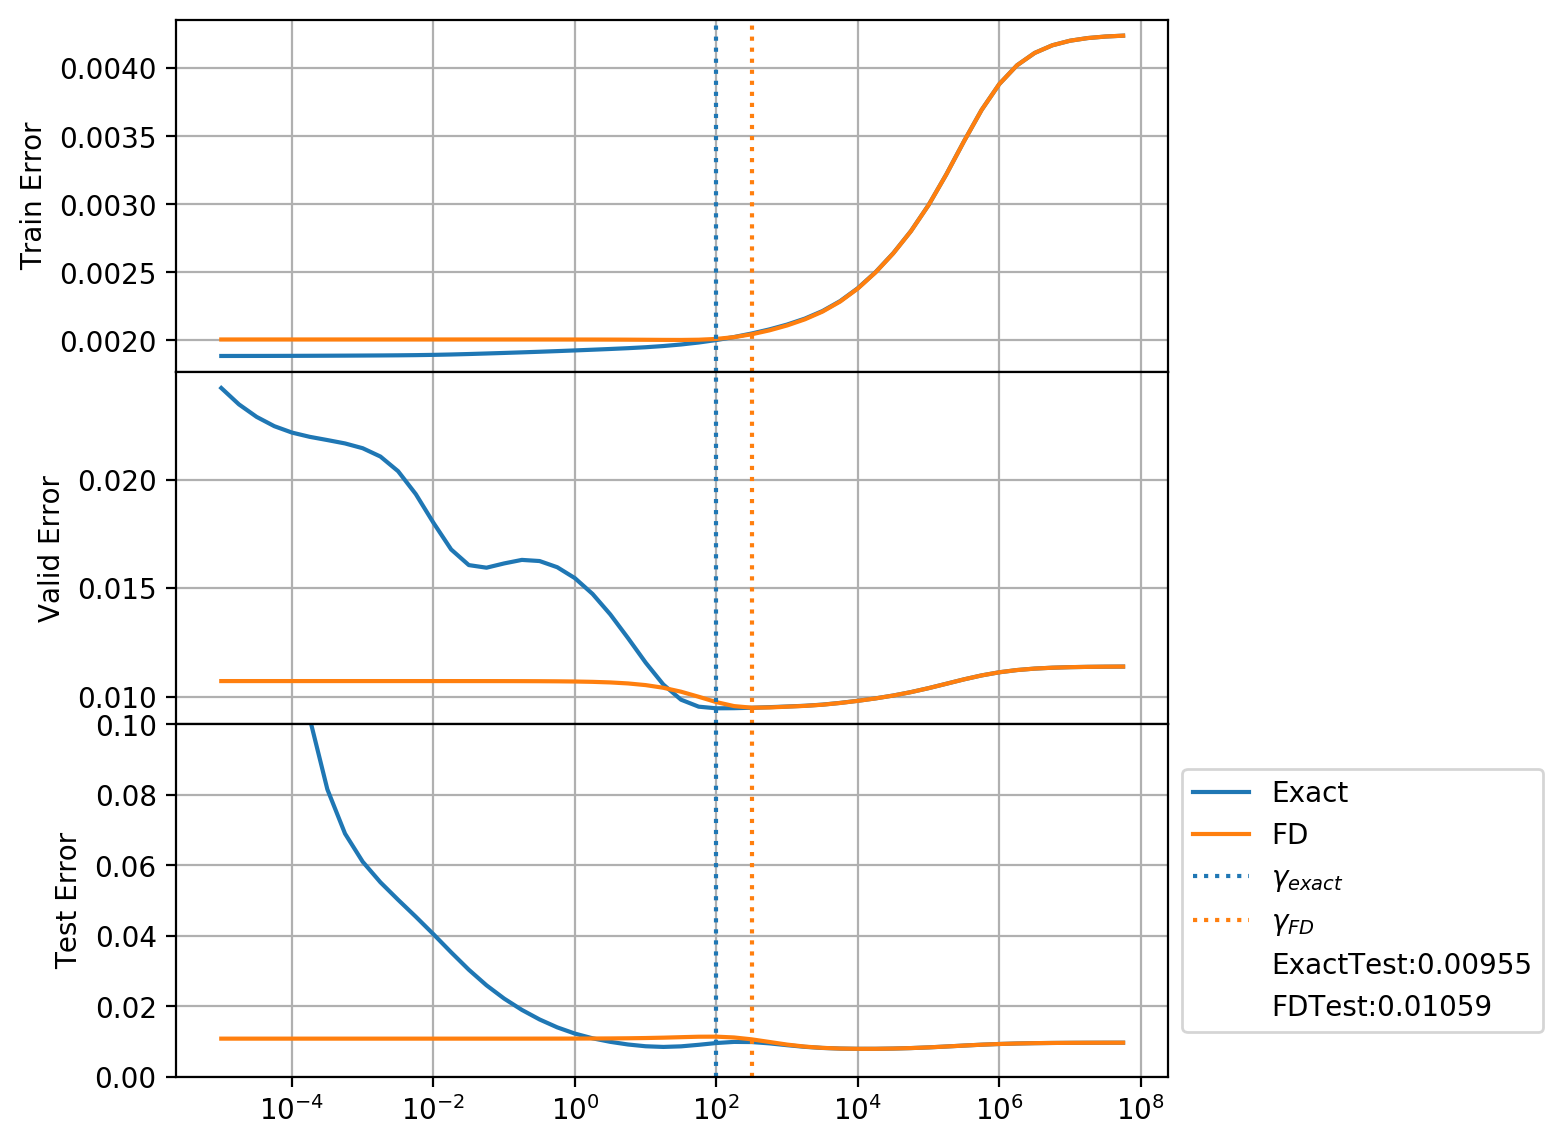

In [40]:
fig, axes = plt.subplots(nrows=3,dpi=200,gridspec_kw = {'hspace':0},figsize=[6.4, 7])
ax_tr, ax_va, ax_te = axes


ax_tr.plot(gammas, my_train_errors,label='Exact')
ax_tr.plot(gammas, fd_train_errors,label='FD')

ax_va.plot(gammas, my_valid_errors,label='Exact')
ax_va.plot(gammas, fd_validation_errors,label='FD')

ax_te.plot(gammas, my_test_errors,label='Exact')
ax_te.plot(gammas, fd_test_errors,label='FD')


ax_tr.set_ylabel('Train Error')
ax_va.set_ylabel('Valid Error')
ax_te.set_ylabel('Test Error')


for ax in axes:
    ax.set_xscale('log',basex=10)
    ax.axvline(exact_optimal_gamma,label=r'$\gamma_{exact}$', linestyle=':',color='C0')
    ax.axvline(fd_optimal_gamma,label=r'$\gamma_{FD}$', linestyle=':',color='C1')
    ax.grid()
    
# Get the test errors:
ax_te.plot([],[],color='white',label=f'ExactTest:{exact_test_error:.5f}')
ax_te.plot([],[],color='white',label=f'FDTest:{fd_test_error:.5f}')


ax_te.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
ax_te.set_ylim(0,0.1)

## 3. Sketching Ridge Regression with RP

Now let's do the same thing with an RP implementation for sketching.
We will fit the method in both `classical` and `hessian` regimes.

In [41]:
class RPRR(RidgeRegression):
    def __init__(self, rp_dim:int,gamma,rp_method='Classical',rp_mode='Gaussian',solve_method='Exact'):
        """
        Approximate ridge regression using random projections.

        rp_dim (int)    : the number of rows retained in the random projection.
        rp_method (str) : The method to use (Classical or Hessian) 
        rp_mode (str)   : sketch mode used to decide on the sketch.
        gamma : float   : the regularisation parameter for ridge regression.
        """
        self.rp_dim       = rp_dim
        self.rp_method    = rp_method
        self.rp_mode      = rp_mode
        self.solve_method = solve_method
        if self.rp_method not in ['Classical', 'Hessian']:
            raise NotImplementedError('Only Classical and Hessian methods are supported.')
        if self.rp_mode not in ['Gaussian', 'SJLT']:
            raise NotImplementedError('Only Gaussian and SJLT modes are supported.')
        if self.solve_method not in ['Exact','ShiWoodbury']:
            raise NotImplementedError('Only Exact and ShiWoodbury methods are implemented')
        if not isinstance(gamma,list):
            self.gamma = [gamma]
        else:
            self.gamma = gamma
    
    def fit(self,data,targets):
        '''
        Fits the ridge model to gamma (which can be a single float or list/ndarray).
        '''
        _,d = data.shape
        X, y = self._preprocess_data(data, targets)
        # Perform self._sketch() once to avoid recomputing
        self._sketch(np.c_[X,y]) 
        self.params = {
            a : {
            'coef_'   :  np.zeros(d)
                     } for a in self.gamma}
        # Can potentially parallelise this loop for better time performance
        for a in self.gamma:
            # There should be either 1 or n_targets penalties
            gamma_reg = np.asarray(a, dtype=X.dtype).ravel() # shift regularisation by the alpha parameter
            assert gamma_reg.size == 1
            weights = self._solve(X,y,gamma_reg)
            self.params[a]['coef_'] = weights
        
    
            
    def _solve(self, X, y,reg):
        '''
        Obtains the inverse term explicitly
        '''
        if self.rp_method == 'Classical':
            #B,z = self._fit_classical(X,y) 
            B, z = self.SX, self.Sy
            if self.solve_method == 'ShiWoodbury':
                return self._small_space_solve(X,y,reg)
            else:
                return (np.linalg.pinv(B.T@B + reg*np.eye(X.shape[1])))@(B.T@z) 
        if self.rp_method == 'Hessian':
            B,z = self.SX, y ##self._fit_hessian(X,y)
            if self.solve_method == 'ShiWoodbury':
                return self._small_space_solve(X,y,reg)
            else:
                return (np.linalg.pinv(B.T@B + reg*np.eye(X.shape[1])))@(X.T@z)

    def _sketch(self,Xy,seed=10):
        '''
        Performs the sketch depending on the chosen mode.
        '''
        np.random.seed(seed)
        if self.rp_mode == 'Gaussian':
            sk = self._gaussian_projection(Xy,self.rp_dim)
        elif self.rp_mode == 'SJLT':
            sk = self._sparse_projection(Xy,self.rp_dim)
        else:
            raise NotImplementedError
        self.SX, self.Sy = sk[:,:-1], sk[:,-1]
            
    def _sparse_projection(self,mat,sparsity=1,random_seed=10):
        """
        Performs the sparse johnson lindenstrauss transform of Kane and Nelson
        """
        [n,_] = mat.shape
        sketch = np.zeros((self.rp_dim ,n),dtype=float)
        for i in range(n):
            nnz_loc = np.random.choice(self.rp_dim ,size=sparsity,replace=False)
            nnz_sign = np.random.choice([-1,1],size=sparsity,replace=True)
            sketch[nnz_loc,i] = nnz_sign
        self.sketch_mat = sketch
        return (1./np.sqrt(sparsity))*sketch@mat

    def _gaussian_projection(self,mat,random_seed=10):
        """
        Performs the sparse johnson lindenstrauss transform of Kane and Nelson
        """
        [n,_] = mat.shape
        np.random.seed(random_seed)
        S = np.random.randn(self.rp_dim,n) / np.sqrt(self.rp_dim)
        self.sketch_mat = S
        return S@mat
    
    def _small_space_solve(self,X,y,reg):
        U,S,Vt = linalg.svd(self.SX,full_matrices=False)
        V = Vt.T
        inv_diag = np.linalg.pinv(np.diag(S**2 + reg)) #1./(S**2 + self.gamma)
        if self.rp_method == 'Classical':
            z = self.SX.T@self.Sy
        else:
            z = X.T@y
        first_term = (V@(inv_diag))@(Vt@z)
        second_term = (1./reg)*z
        third_term = (1./reg)*V@(Vt@z)
        return first_term + second_term - third_term

In [51]:
print('(CL)assical model')
cl_ridge = RPRR(rp_dim=256,gamma=gammas,rp_method='Classical',rp_mode='SJLT',solve_method='ShiWoodbury')
cl_ridge.fit(X_train_poly,y_train)
cl_train_errors  = cl_ridge.get_errors(X_train_poly,y_train)
cl_valid_errors  = cl_ridge.get_errors(X_valid_poly,y_valid)
cl_test_errors   = cl_ridge.get_errors(X_test_poly,y_test)

############ Hessian Sketch MODEL ############
print('(H)essian (S)ketch model')
hs_ridge = RPRR(rp_dim=256,gamma=gammas,rp_method='Hessian',rp_mode='SJLT',solve_method='ShiWoodbury')
hs_ridge.fit(X_train_poly,y_train)
hs_train_errors  = hs_ridge.get_errors(X_train_poly,y_train)
hs_valid_errors  = hs_ridge.get_errors(X_valid_poly,y_valid)
hs_test_errors   = hs_ridge.get_errors(X_test_poly, y_test)

(CL)assical model
(H)essian (S)ketch model


In [52]:
# Optimal hyperparameter selection and test loss for RP methods
cl_optimal_gamma = gammas[cl_valid_error.argmin()]
cl_test_error = cl_test_errors[cl_valid_error.argmin()]

hs_optimal_gamma = gammas[hs_valid_error.argmin()]
hs_test_error = hs_test_errors[hs_valid_error.argmin()]

(0, 0.1)

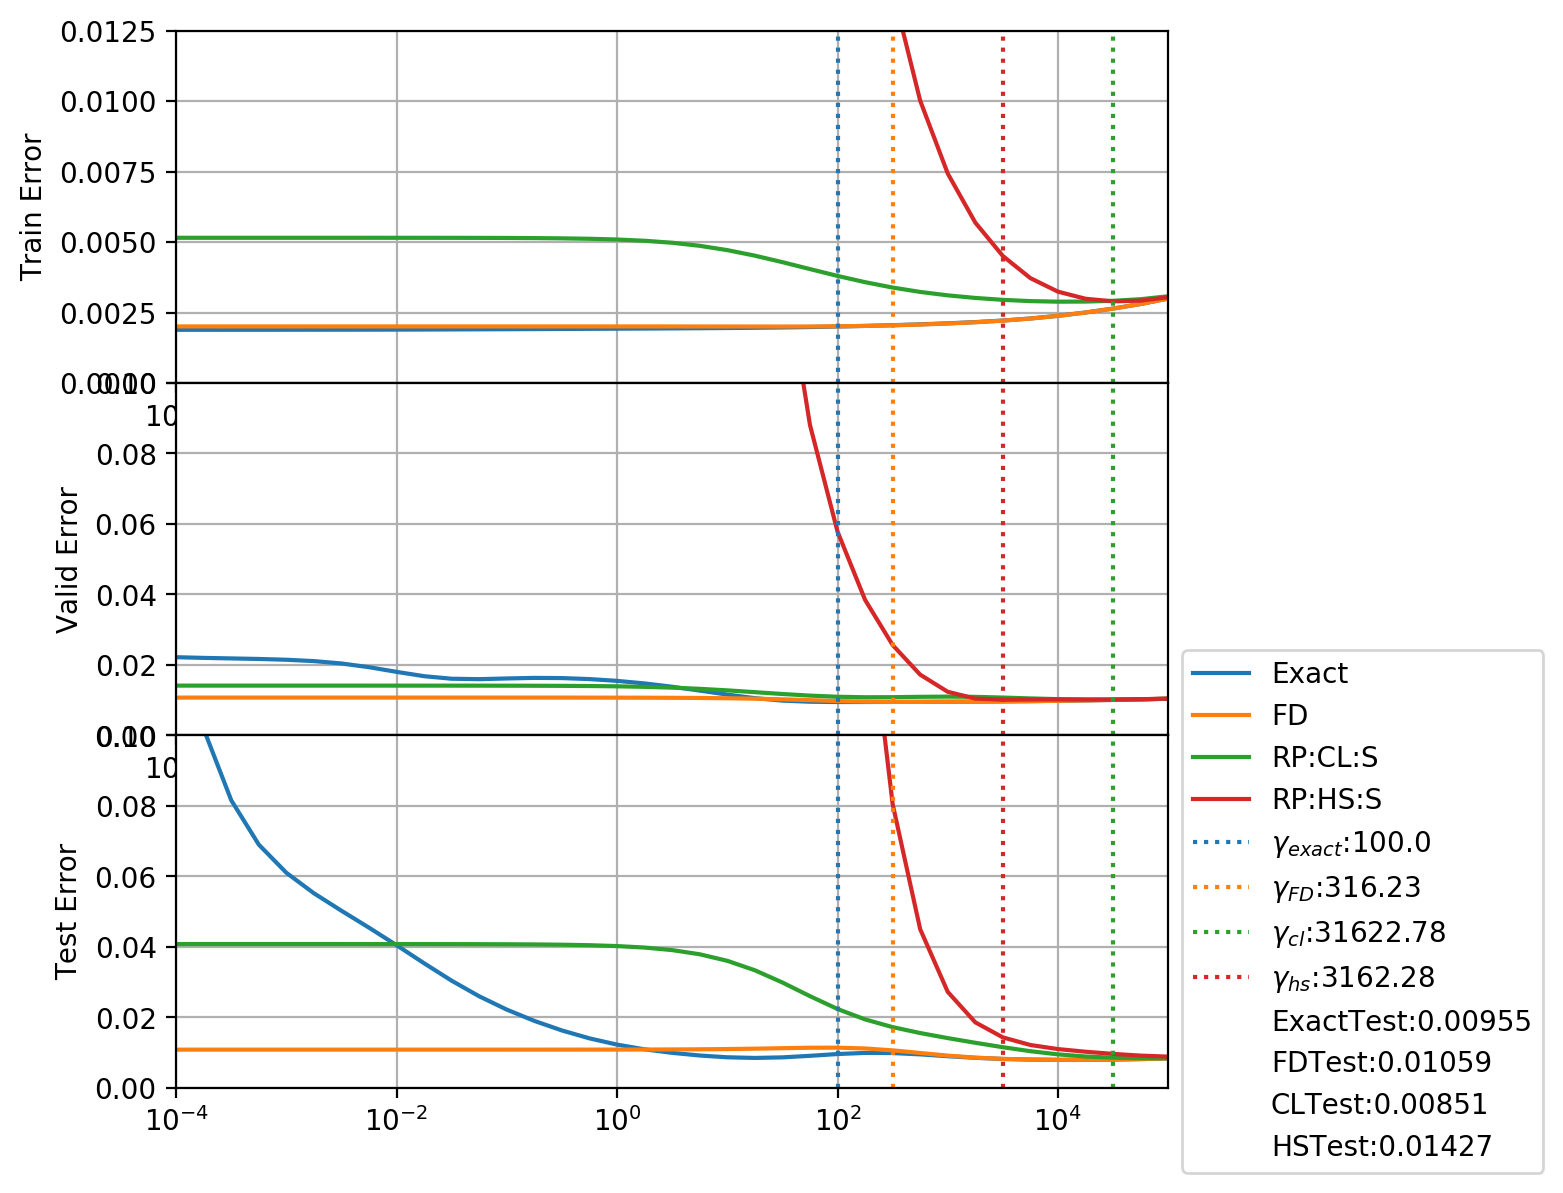

In [70]:
fig, axes = plt.subplots(nrows=3,dpi=200,gridspec_kw = {'hspace':0},figsize=[6.4, 7])
ax_tr, ax_va, ax_te = axes


ax_tr.plot(gammas, my_train_errors,label='Exact')
ax_tr.plot(gammas, fd_train_errors,label='FD')
ax_tr.plot(gammas, cl_train_error,label='RP:CL:S')
ax_tr.plot(gammas, hs_train_error,label='RP:Hs:S')

ax_va.plot(gammas, my_valid_errors,label='Exact')
ax_va.plot(gammas, fd_validation_errors,label='FD')
ax_va.plot(gammas, cl_valid_error,label='RP:CL:S')
ax_va.plot(gammas, hs_valid_error,label='RP:Hs:S')

ax_te.plot(gammas, my_test_errors,label='Exact')
ax_te.plot(gammas, fd_test_errors,label='FD')
ax_te.plot(gammas, cl_test_errors,label='RP:CL:S')
ax_te.plot(gammas, hs_test_errors,label='RP:HS:S')


ax_tr.set_ylabel('Train Error')
ax_va.set_ylabel('Valid Error')
ax_te.set_ylabel('Test Error')

# Set the y axes
ax_tr.set_ylim(0.,0.0125)
ax_va.set_ylim(0,0.1)
ax_te.set_ylim(0,0.1)




# Double braces needed in latex for escaping out of the .format() call
for ax in axes:
    ax.set_xscale('log',basex=10)
    ax.axvline(exact_optimal_gamma,label=r'$\gamma_{{exact}}$:{}'.format(exact_optimal_gamma), linestyle=':',color='C0')
    ax.axvline(fd_optimal_gamma,label=r'$\gamma_{{FD}}$:{:.2f}'.format(fd_optimal_gamma), linestyle=':',color='C1')
    ax.axvline(cl_optimal_gamma,label=r'$\gamma_{{cl}}$:{:.2f}'.format(cl_optimal_gamma), linestyle=':',color='C2')
    ax.axvline(hs_optimal_gamma,label=r'$\gamma_{{hs}}$:{:.2f}'.format(hs_optimal_gamma), linestyle=':',color='C3')
    ax.grid()
    # Set the x axes 
    ax.set_xlim(1E-4,1E5)
    
# Get the test errors:
ax_te.plot([],[],color='white',label=f'ExactTest:{exact_test_error:.5f}')
ax_te.plot([],[],color='white',label=f'FDTest:{fd_test_error:.5f}')
ax_te.plot([],[],color='white',label=f'CLTest:{cl_test_error:.5f}')
ax_te.plot([],[],color='white',label=f'HSTest:{hs_test_error:.5f}')


ax_te.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
ax_te.set_ylim(0,0.1)

## 4. Comparing the methods over random splits.

Rather than just performing one split, we would like to test this on many independently randomly sampled train test splits.

In [81]:
all_train_data = np.concatenate((X_train_poly, X_valid_poly),axis=0)
all_train_labels = np.concatenate((y_train, y_valid),axis=0)

In [82]:
# Model setup
gammas = [10**_ for _ in np.arange(-5,8,step=0.25)]
sketch_dimension = 256
num_trials = 3


In [175]:
# Output results

exact_results = {
    'train_error' : np.zeros((len(gammas),num_trials)),
    'valid_error' : np.zeros((len(gammas),num_trials)),
    'test_error'  : np.zeros((len(gammas),num_trials))
}

rfd_results = {
    'train_error' : np.zeros((len(gammas),num_trials)),
    'valid_error' : np.zeros((len(gammas),num_trials)),
    'test_error'  : np.zeros((len(gammas),num_trials))
}

cl_results = {
    'train_error' : np.zeros((len(gammas),num_trials)),
    'valid_error' : np.zeros((len(gammas),num_trials)),
    'test_error'  : np.zeros((len(gammas),num_trials))
}

hs_results = {
    'train_error' : np.zeros((len(gammas),num_trials)),
    'valid_error' : np.zeros((len(gammas),num_trials)),
    'test_error'  : np.zeros((len(gammas),num_trials))
}


In [176]:
for exp in range(num_trials):
    print('Experiment: ', exp)
    # Generate new train-validation split
    _X_train, _X_valid, _y_train, _y_valid = train_test_split(all_train_data, all_train_labels, test_size=0.2,random_state=exp)
    
    ############ EXACT MODEL ############
    print('...exact model')
    exact_ridge = RidgeRegression(gammas)
    exact_ridge.fit(_X_train, _y_train)
    exact_results['train_error'][:,exp]  = exact_ridge.get_errors(_X_train, _y_train)
    exact_results['valid_error'][:,exp]  = exact_ridge.get_errors(_X_valid, _y_valid)
    exact_results['test_error'][:,exp]   = exact_ridge.get_errors(X_test_poly, y_test)
    
    ############ RFD MODEL ############
    print('...RFD model')
    rfd_ridge = FDRR(fd_dim=sketch_dimension,gamma=gammas,fd_mode='RFD',solve_method='ShiWoodbury')
    rfd_ridge.fit(_X_train, _y_train)
    rfd_results['train_error'][:,exp]  = rfd_ridge.get_errors(_X_train, _y_train)
    rfd_results['valid_error'][:,exp]  = rfd_ridge.get_errors(_X_valid, _y_valid)
    rfd_results['test_error'][:,exp]   = rfd_ridge.get_errors(X_test_poly, y_test)
    
    ############ Classical Sketch MODEL ############
    print('...(CL)assical model')
    cl_ridge = RPRR(rp_dim=sketch_dimension,gamma=gammas,rp_method='Classical',rp_mode='SJLT',solve_method='ShiWoodbury')
    cl_ridge.fit(_X_train, _y_train)
    cl_results['train_error'][:,exp]  = cl_ridge.get_errors(_X_train, _y_train)
    cl_results['valid_error'][:,exp]  = cl_ridge.get_errors(_X_valid, _y_valid)
    cl_results['test_error'][:,exp]   = cl_ridge.get_errors(X_test_poly, y_test)
    
    ############ Hessian Sketch MODEL ############
    print('...(H)essian (S)ketch model')
    hs_ridge = RPRR(rp_dim=sketch_dimension,gamma=gammas,rp_method='Hessian',rp_mode='SJLT',solve_method='ShiWoodbury')
    hs_ridge.fit(_X_train, _y_train)
    hs_results['train_error'][:,exp]  = hs_ridge.get_errors(_X_train, _y_train)
    hs_results['valid_error'][:,exp]  = hs_ridge.get_errors(_X_valid, _y_valid)
    hs_results['test_error'][:,exp]   = hs_ridge.get_errors(X_test_poly, y_test)
    
    
    

Experiment:  0
...exact model
...RFD model
...(CL)assical model
...(H)essian (S)ketch model
Experiment:  1
...exact model
...RFD model
...(CL)assical model
...(H)essian (S)ketch model
Experiment:  2
...exact model
...RFD model
...(CL)assical model
...(H)essian (S)ketch model


To understand the variation, let's also get the means and standard deviations.

In [177]:
for dictionary in [exact_results,rfd_results, cl_results, hs_results]:
    temp_mean = {
        'mean_train_error' : None,
        'mean_valid_error' : None,
        'mean_test_error'  : None,
    }
    
    temp_std = {
        'std_train_error' : None,
        'std_valid_error' : None,
        'std_test_error'  : None,
    }
    for k,v in dictionary.items():
        v_mean = np.mean(v,axis=1)
        v_std  = np.std(v,axis=1)
        
        if k == 'train_error':
            temp_mean['mean_train_error'] = v_mean
            temp_std['std_train_error']   = v_std
        elif k == 'valid_error':
            temp_mean['mean_valid_error'] = v_mean
            temp_std['std_valid_error']   = v_std
        elif k == 'test_error':
            temp_mean['mean_test_error'] = v_mean
            temp_std['std_test_error']   = v_std
        else:
            raise Exception('Key not found.')

    for k,v in temp_mean.items():
        dictionary[k] = v
    for k,v in temp_std.items():
        dictionary[k] = v


In [178]:
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(exact_results)

In [179]:
# pp.pprint(rfd_results)

In [180]:
# Optimal hyperparameter selection and test errors

exact_optimal_gamma = gammas[exact_results['mean_valid_error'].argmin()]
exact_opt_mean_test_error = exact_results['mean_test_error'][exact_results['mean_valid_error'].argmin()]

rfd_optimal_gamma = gammas[rfd_results['mean_valid_error'].argmin()]
rfd_opt_mean_test_error = rfd_results['mean_test_error'][rfd_results['mean_valid_error'].argmin()]

cl_optimal_gamma = gammas[cl_results['mean_valid_error'].argmin()]
cl_opt_mean_test_error = cl_results['mean_test_error'][cl_results['mean_valid_error'].argmin()]

hs_optimal_gamma = gammas[hs_results['mean_valid_error'].argmin()]
hs_opt_mean_test_error = hs_results['mean_test_error'][hs_results['mean_valid_error'].argmin()]

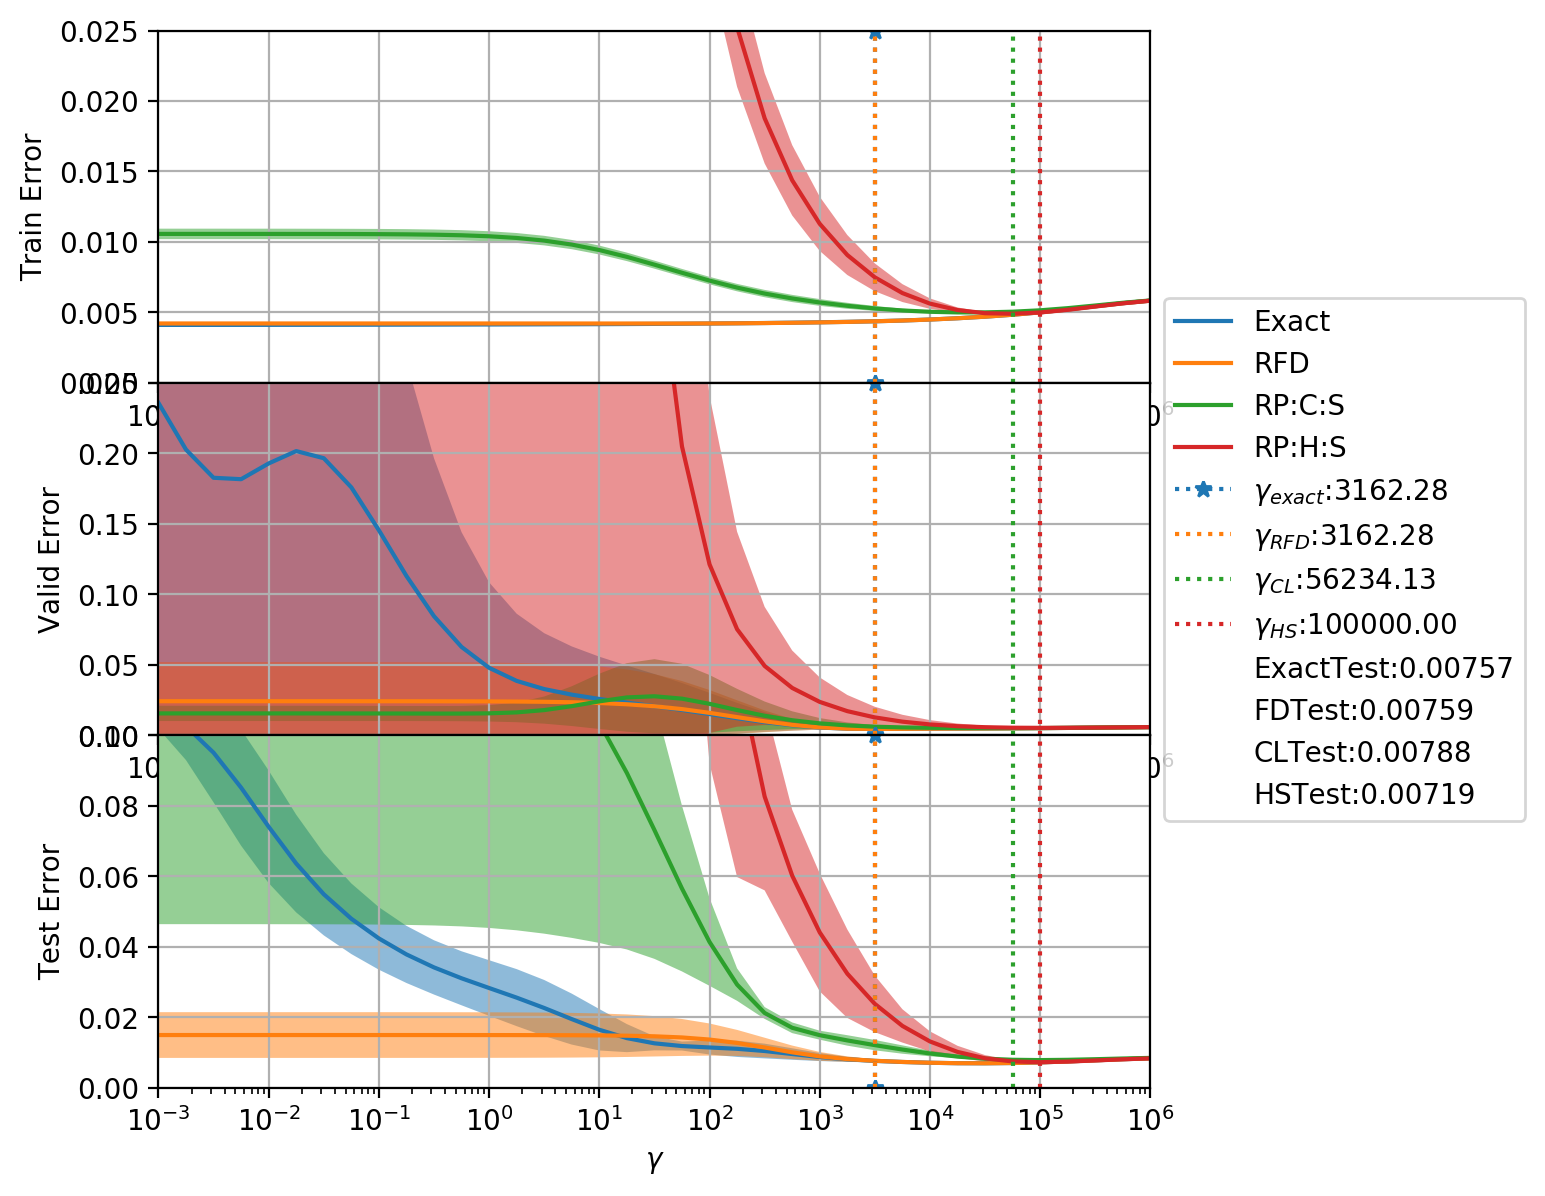

In [190]:
fig, axes = plt.subplots(nrows=3,dpi=200,gridspec_kw = {'hspace':0},figsize=[6.4, 7])
ax_tr, ax_va, ax_te = axes
ALPHA = 0.5 # FOR SHADING

labels = ['Exact', 'RFD', 'RP:C:S', 'RP:H:S']
dicts = [exact_results, rfd_results, cl_results,hs_results]
############ TRAINING PLOT ############
for l,m in zip(labels,dicts):
    _mean = m['mean_train_error']
    _std  = m['std_train_error']
    ax_tr.plot(gammas, _mean, label=l)
    
    # TRAIN Fill error region
    ax_tr.fill_between(gammas,_mean - _std, _mean+_std,alpha=ALPHA)
ax_tr.set_ylim(0,0.025)


# # ############ VALIDATION PLOT ############
for l,m in zip(labels,dicts):
    _mean = m['mean_valid_error']
    _std   = m['std_valid_error']
    ax_va.plot(gammas, _mean, label=l)
    
    # VALID Fill error region
    ax_va.fill_between(gammas,_mean - _std, _mean+_std,alpha=ALPHA)
ax_va.set_ylim(0,0.25)



# # ############ TESTING PLOT ############
for l,m in zip(labels,dicts):
    _mean = m['mean_test_error']
    _std   = m['std_test_error']
    ax_te.plot(gammas, m['mean_test_error'], label=l)
    
    # TEST Fill error region
    ax_te.fill_between(gammas,_mean - _std, _mean+_std,alpha=ALPHA)
ax_te.set_ylim(0,0.1)
ax_te.set_xlabel(r'$\gamma$')

ax_tr.set_ylabel('Train Error')
ax_va.set_ylabel('Valid Error')
ax_te.set_ylabel('Test Error')



for ax in axes:
    ax.set_xscale('log',basex=10)
    ax.axvline(exact_optimal_gamma,label=r'$\gamma_{{exact}}$:{:.2f}'.format(exact_optimal_gamma), linestyle=':',marker='*',color='C0')
    ax.axvline(rfd_optimal_gamma,label=r'$\gamma_{{RFD}}$:{:.2f}'.format(rfd_optimal_gamma), linestyle=':',color='C1')
    ax.axvline(cl_optimal_gamma,label=r'$\gamma_{{CL}}$:{:.2f}'.format(cl_optimal_gamma), linestyle=':',color='C2')
    ax.axvline(hs_optimal_gamma,label=r'$\gamma_{{HS}}$:{:.2f}'.format(hs_optimal_gamma), linestyle=':',color='C3')
    ax.grid()
    ax.set_xlim(1E-3,1E6)
    
    
# Get the test errors:
ax_te.plot([],[],color='white',label=f'ExactTest:{exact_opt_mean_test_error:.5f}')
ax_te.plot([],[],color='white',label=f'FDTest:{rfd_opt_mean_test_error:.5f}')
ax_te.plot([],[],color='white',label=f'CLTest:{cl_opt_mean_test_error:.5f}')
ax_te.plot([],[],color='white',label=f'HSTest:{hs_opt_mean_test_error:.5f}')




ax_te.legend(loc='center left', bbox_to_anchor=(1, 1.5))  

A key takeaway from this plot is that the RFD method is much more robust to hyperparameter tuning than the randomized methods.

# Space Benefit

Is there any benefit to using this approach?
At this point we need to distinguish how exactly we compare the methods.  It is clear that the sketch methods keep only an $m \times d$ matrix for training.  This matrix is used to learn the weights which are then queried for the training, validation and test errors.  So we can certainly make the following comparison, "how large is the matrix used for training?"
$$x_{opt} = \left(X^T X + \gamma I_d \right)^{-1} X^T y $$
$$x_{rfd} = \left(B^T B + \gamma I_d \right)^{-1} X^T y $$

Neither of the methods requires explicit construction of the $d \times d$ matrices $X^T X, B^T B$.  The former requires an SVD of $X$ while the latter, keeping only $m < d$ rows permits the use of Woodbury's identity.

In [194]:
space_percentage = fd_ridge.sketch_mat.shape[0] / X_train_poly.shape[0]
print(f'RFD uses {(space_percentage*100):.4f}% of the training data space')

RFD uses 1.9381% of the training data space


## Time Benefit
Is there any time benefit here?